## Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from sklearn.model_selection import train_test_split
from osgeo import gdal
from IPython.display import HTML
from base64 import b64encode
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib import colors 

## Settings

In [2]:
dataset = '../input/land-use-land-cover-time-series/time_series.csv'

classe_info = {
  'not identified':           {'value':0, 'color': '#000000'},
  'soybean':                  {'value':1, 'color': '#ffe32e'},
  'maize':                    {'value':2, 'color': '#FF0000'},
  'cotton':                   {'value':3, 'color': '#0000FF'},
  'coffee':                   {'value':4, 'color': '#75781f'},
  'beans':                    {'value':5, 'color': '#e5eb34'},
  'wheat':                    {'value':6, 'color': '#ff24e5'},
  'sorghum':                  {'value':7, 'color': '#a80a96'},
  'millet':                   {'value':8, 'color': '#fa73eb'},
  'eucalyptus':               {'value':9, 'color': '#c75e0e'},
  'pasture':                  {'value':10, 'color': '#fff68f'},
  'hay':                      {'value':11, 'color': '#c9cf91'},
  'grass':                    {'value':12, 'color': '#12e362'},
  'crotalari':                {'value':13, 'color': '#12e362'},
  'maize+crotalari':          {'value':14, 'color': '#f77159'},
  'cerrado':                  {'value':15, 'color': '#5e2e10'},
  'conversion area':          {'value':16, 'color': '#12e0e3'},
  'uncultivated soil':        {'value':17, 'color': '#a9b0b0'},
  'ncc':                      {'value':18, 'color': '#12e362'},
  'brachiaria':               {'value':19, 'color': '#12e362'},
}

classes = {x : y.get('value') for x, y in classe_info.items()}

classe_colors = [y.get('color') for x, y in classe_info.items()]

features = ['red', 'nir', 'swir']
n_features = len(features)

sequence_size = 30

model_dir = './logs'

## Load dataset

In [3]:
df = pd.read_csv(dataset)
df.head()

,id,date,red,nir,swir,class
0,0,2017-06-10,0.125,0.263,0.249,5
1,0,2017-06-26,0.149,0.283,0.254,5
2,0,2017-07-12,0.170,0.304,0.284,17
3,0,2017-07-28,0.191,0.319,0.302,17
4,0,2017-08-13,0.213,0.343,0.319,17


In [4]:
df['class_name'] = df.apply(lambda row: list(classes.keys())[list(classes.values()).index(row['class'])], axis = 1) 
df['date'] = pd.to_datetime(df['date'])
df.head()

,id,date,red,nir,swir,class,class_name
0,0,2017-06-10,0.125,0.263,0.249,5,beans
1,0,2017-06-26,0.149,0.283,0.254,5,beans
2,0,2017-07-12,0.170,0.304,0.284,17,uncultivated soil
3,0,2017-07-28,0.191,0.319,0.302,17,uncultivated soil
4,0,2017-08-13,0.213,0.343,0.319,17,uncultivated soil


## Plot time series

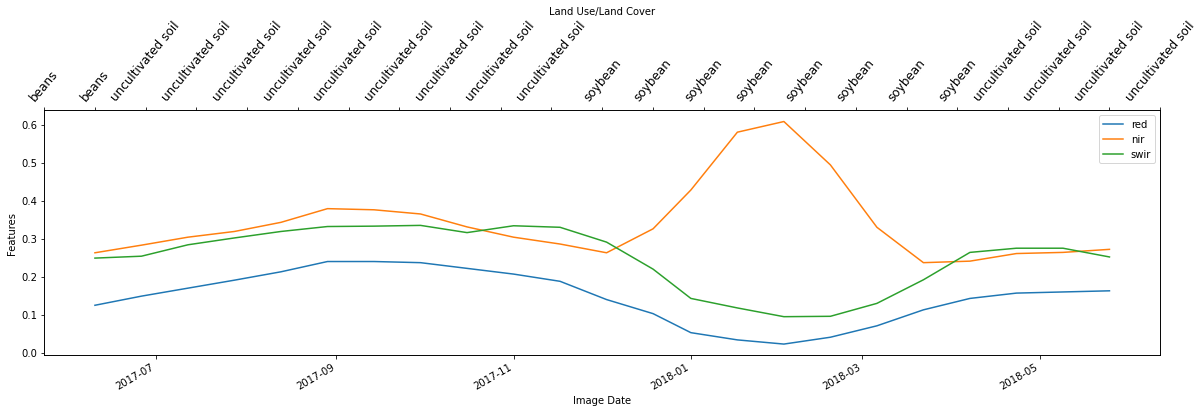

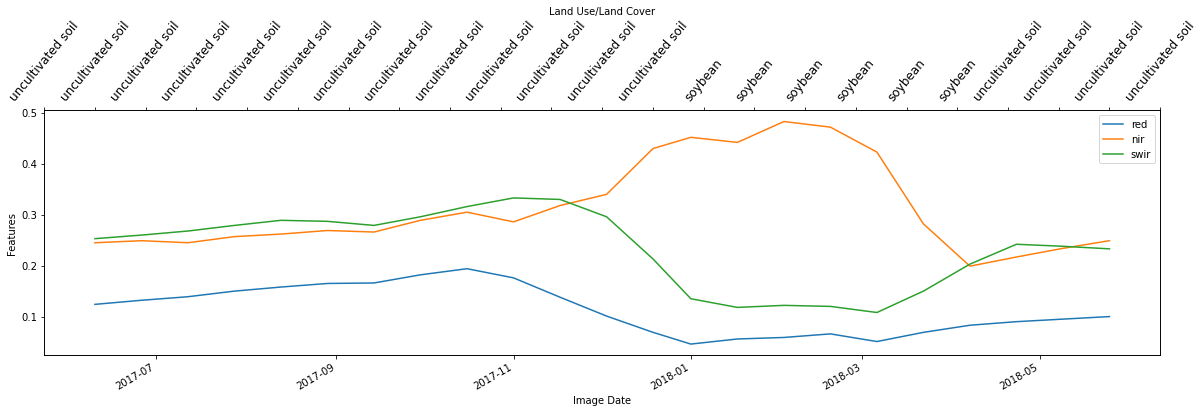

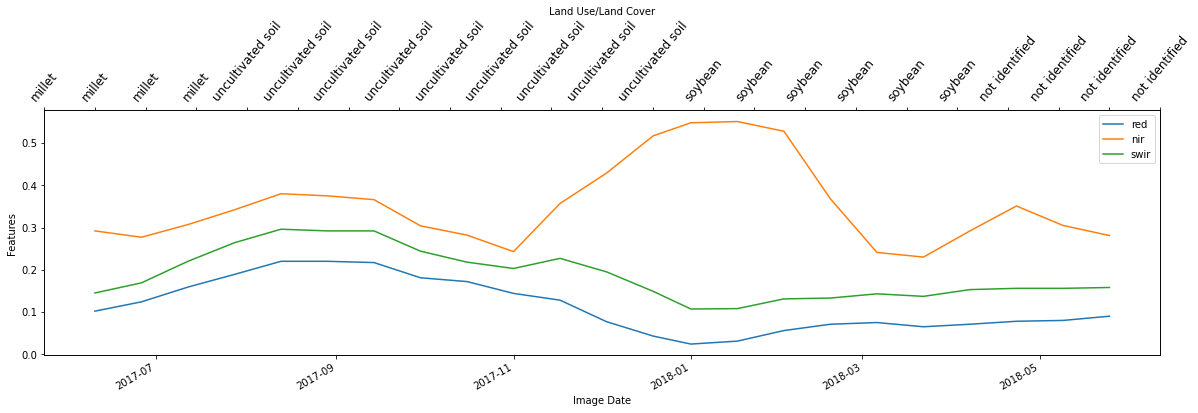

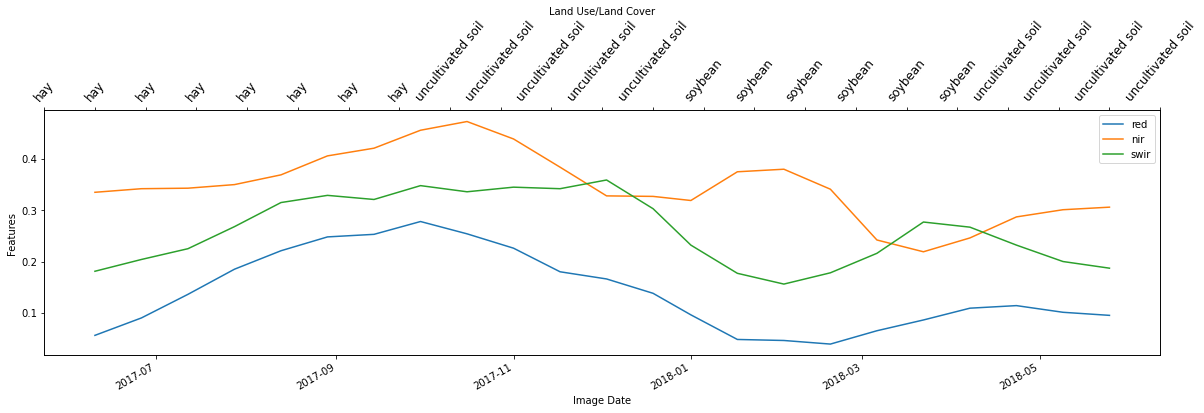

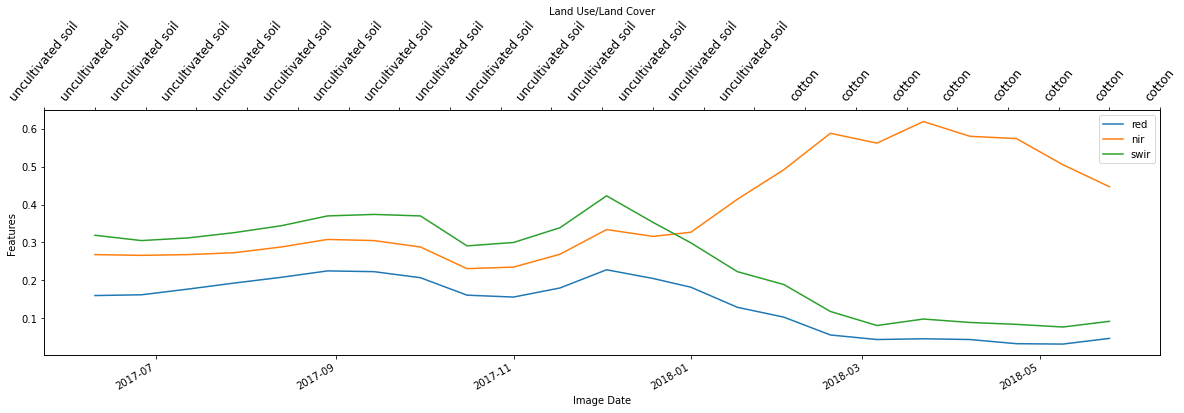

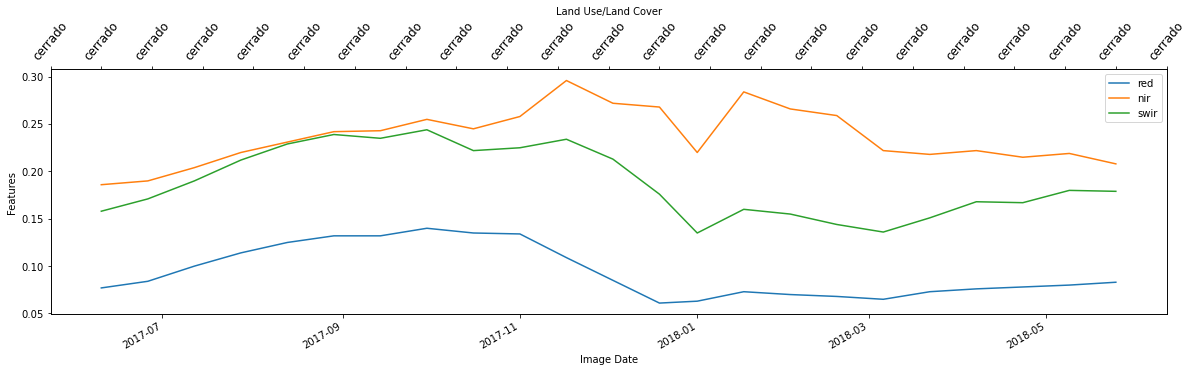

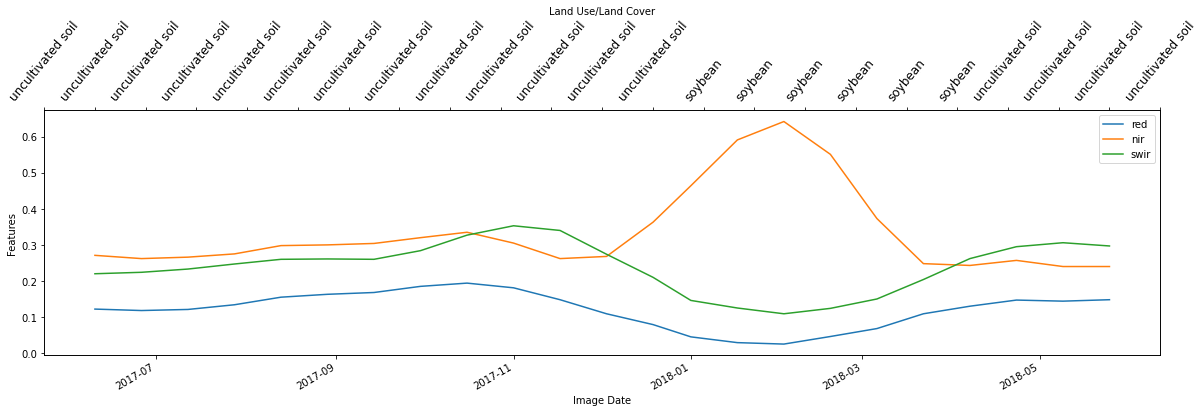

In [5]:
points = df.id.unique()

for point in points[:7]:
    point_df = df[df['id'] == point]
    point_df = point_df.sort_values(by=['date'])
    ax = point_df.plot(x='date', y=features, figsize=(20, 5))

    axes1 = plt.gca()
    axes2 = axes1.twiny()
    
    class_names = point_df['class_name'].tolist()
    axes2.set_xticks(np.arange(len(class_names)))
    axes2.set_xticklabels(class_names, rotation=50, fontsize=12, minor=False)

    axes1.set_ylabel("Features")
    axes1.set_xlabel("Image Date")
    axes2.set_xlabel("Land Use/Land Cover")

## Prepare datasets

In [6]:
X = []
y = []

for point in points:
    point_df = df[df['id'] == point]
    point_df = point_df.sort_values(by=['date'])
    
    x_values = point_df[features].to_numpy()
    y_values = point_df['class'].tolist()

    x_values = tf.keras.preprocessing.sequence.pad_sequences([x_values], 
                                                             maxlen=sequence_size, dtype='float32')[0]
    y_values = tf.keras.preprocessing.sequence.pad_sequences([y_values], 
                                                             maxlen=sequence_size, 
                                                             value=classes.get('not identified'), dtype='float32')[0]
    
    X.append(x_values)
    
    labels = []
    for y_value in y_values:
        values = np.zeros(len(classes))
        np.put(values, [y_value], [1])
        labels.append(values)
        
    y.append(labels)
    
X = np.array(X)
y = np.array(y)

X = X.reshape((X.shape[0], X.shape[1], n_features))

X.shape, y.shape

((54999, 30, 3), (54999, 30, 20))

## Split dataset in train, validation and test sets

In [7]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2)
X_validation, X_test, y_validation, y_test = train_test_split(X_validation, y_validation, test_size=0.5)

print("Train: ", len(X_train), "\nValidation: ", len(X_validation), "\nTest:", len(X_test))

Train:  43999 
Validation:  5500 
Test: 5500


In [8]:
X_train.shape, y_train.shape

((43999, 30, 3), (43999, 30, 20))

## Create LSTM model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               163200    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 100)           20100     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 20)            2020      
_________________________________________________________________
activation (Activation)      (None, 30, 20)            0         
Total params: 506,120
Trainable params: 506,120
Non-trainable params: 0
__________________________________________________

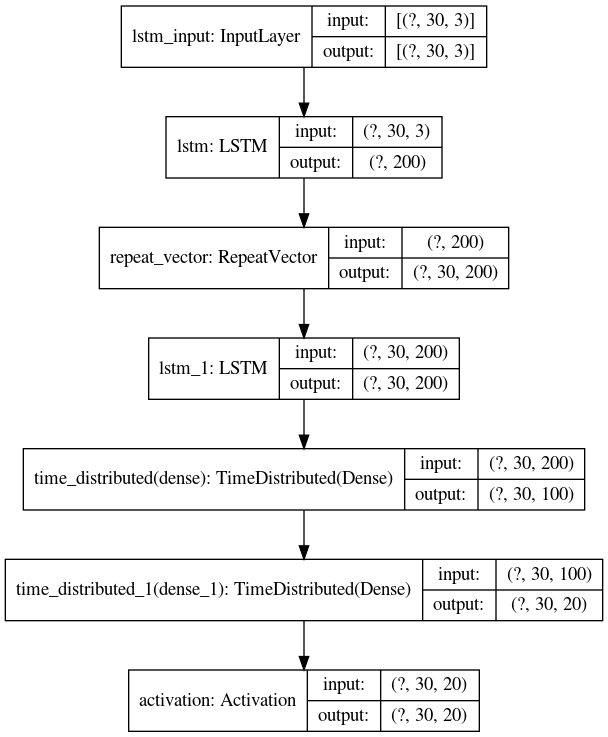

In [11]:
def LSTM(n_classes, sequence_size, n_features):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.LSTM(200, input_shape=(sequence_size, n_features)))
    
    model.add(tf.keras.layers.RepeatVector(sequence_size))
    
    model.add(tf.keras.layers.LSTM(200, activation='relu', return_sequences=True))
    
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(100, activation='relu')))

    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_classes)))
    
    model.add(tf.keras.layers.Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model
              
model = LSTM(n_classes=len(classes), sequence_size=sequence_size, n_features=n_features)
              
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True, to_file='/kaggle/working/model.png')

## Create callbacks

In [12]:
checkpoint_path = "{dir}/model.ckpt".format(dir=model_dir)

latest = tf.train.latest_checkpoint(model_dir)

if latest:
    model.load_weights(latest)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', 
                                            baseline=None, restore_best_weights=True)

callbacks = [cp_callback, es_callback]

## Train model

In [13]:
epochs = 100
batch_size = 128

history = model.fit(x=X_train, y=y_train, 
          validation_data=(X_validation, y_validation),
          epochs=epochs, batch_size=batch_size, callbacks=callbacks, use_multiprocessing=False, verbose=1)

Epoch 1/100
344/344 [==============================] - 19s 54ms/step - loss: 1.2424 - accuracy: 0.6409 - val_loss: 0.8085 - val_accuracy: 0.7510
Epoch 2/100
344/344 [==============================] - 18s 53ms/step - loss: 0.6986 - accuracy: 0.7810 - val_loss: 0.6335 - val_accuracy: 0.7890
Epoch 3/100
344/344 [==============================] - 17s 49ms/step - loss: 0.5752 - accuracy: 0.8127 - val_loss: 0.5287 - val_accuracy: 0.8265
Epoch 4/100
344/344 [==============================] - 18s 52ms/step - loss: 0.5037 - accuracy: 0.8339 - val_loss: 0.4977 - val_accuracy: 0.8353
Epoch 5/100
344/344 [==============================] - 17s 50ms/step - loss: 0.4600 - accuracy: 0.8454 - val_loss: 0.4559 - val_accuracy: 0.8475
Epoch 6/100
344/344 [==============================] - 18s 54ms/step - loss: 0.4264 - accuracy: 0.8556 - val_loss: 0.4192 - val_accuracy: 0.8568
Epoch 7/100
344/344 [==============================] - 18s 51ms/step - loss: 0.3990 - accuracy: 0.8637 - val_loss: 0.3881 - val_ac

## Plot training and validation loss

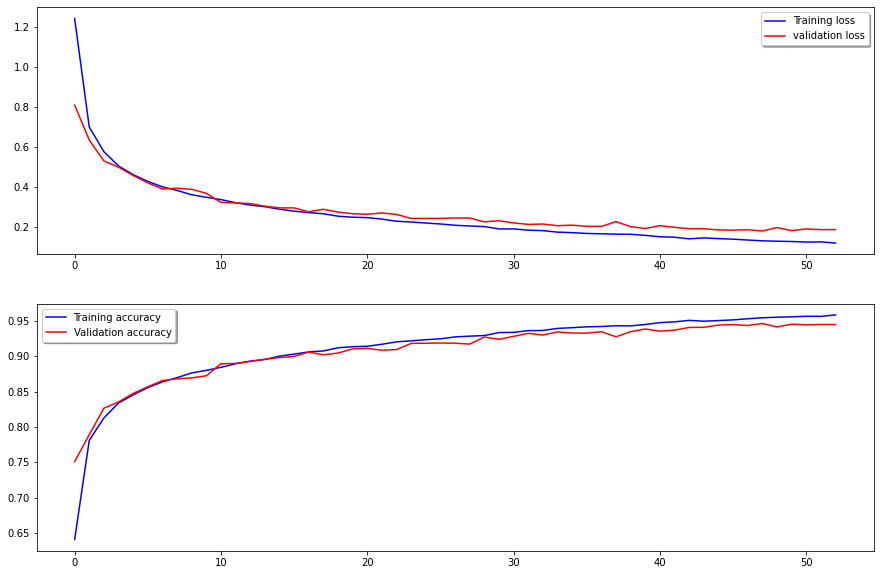

In [14]:
fig, ax = plt.subplots(2,1, figsize=(15, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Evaluate model

In [15]:
model.evaluate(X_test, y_test, batch_size=128)

43/43 [==============================] - 0s 9ms/step - loss: 0.1792 - accuracy: 0.9454


[0.17919796705245972, 0.9454242587089539]

## Save model

In [16]:
model.save('model.h5')

## Predict image

### Load image

In [17]:
image_path = '../input/land-use-land-cover-time-series/image_2019-10-01_2020-10-01.tif'
predicted_path = './predicted_2019-10-01_2020-10-01.tif'
data_source = gdal.Open(image_path)
image = data_source.ReadAsArray()
image.shape

(69, 1401, 816)

### Reshape image

In [18]:
flat_image = image.reshape(image.shape[0],
                           image.shape[1] * image.shape[2])

flat_image = flat_image.transpose()

flat_image = flat_image.reshape((flat_image.shape[0],
                                 int(flat_image.shape[1] / n_features), n_features))

flat_image = np.array(flat_image).astype(float)

flat_image.shape

(1143216, 23, 3)

### Pad time series

In [19]:
padded_image = tf.keras.preprocessing.sequence.pad_sequences(flat_image, maxlen=sequence_size, dtype='float32')

padded_image.shape

(1143216, 30, 3)

### Reescale time series values. From 0-10000 to 0-1

In [20]:
rescaled_image = padded_image / 10000.0

### Predict time series

In [21]:
flat_predicted = model.predict(rescaled_image, batch_size=1024)
flat_predicted.shape

(1143216, 30, 20)

In [22]:
flat_labels = np.argmax(flat_predicted, axis=2)
flat_predicted.shape, '-->', flat_labels.shape

((1143216, 30, 20), '-->', (1143216, 30))

In [24]:
flat_labels.shape, flat_image.shape[1]

((1143216, 30), 23)

In [27]:
valid_flat_labels = flat_labels[:,-flat_image.shape[1]:]
valid_flat_labels.shape

(1143216, 23)

In [28]:
predicted_image = valid_flat_labels.reshape((image.shape[1], image.shape[2], valid_flat_labels.shape[-1]))
predicted_image.shape

(1401, 816, 23)

In [29]:
predicted_image = predicted_image[:, :, predicted_image.shape[-1] - image.shape[0]:]
predicted_image.shape

(1401, 816, 23)

In [30]:
# save results
driver = data_source.GetDriver()
output_dataset = driver.Create(predicted_path,
                               predicted_image.shape[1],
                               predicted_image.shape[0],
                               predicted_image.shape[-1],
                               gdal.GDT_Byte,
                               ['COMPRESS=DEFLATE'])
output_dataset.SetGeoTransform(data_source.GetGeoTransform())
output_dataset.SetProjection(data_source.GetProjection())

for band_id in range(predicted_image.shape[-1]):
    band_data = predicted_image[:, : , band_id]        
    output_dataset.GetRasterBand(band_id + 1).WriteArray(band_data, 0, 0)
output_dataset.FlushCache()
del output_dataset
print("Completed!")

Completed!


## Load predicted image

In [31]:
data_source = gdal.Open(predicted_path)
image = data_source.ReadAsArray()
image.shape

(23, 1401, 816)

## Plot predicted image

In [32]:
def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

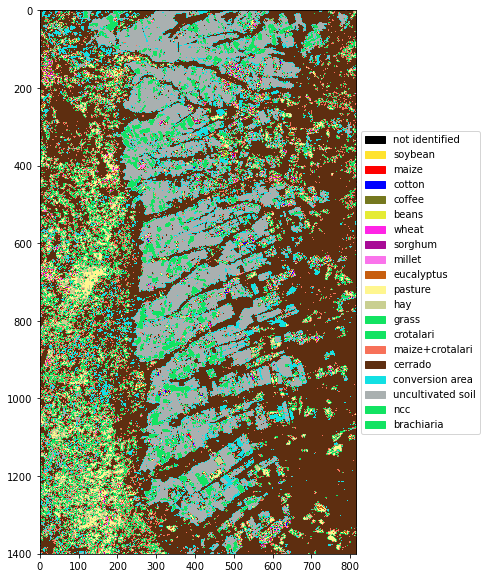

In [33]:
fig, ax = plt.subplots(figsize=(15, 10))

ims = []

cmap = colors.ListedColormap(classe_colors) 

for band in image:
    im = ax.imshow(band, vmin=0, vmax=len(classe_colors)-1, cmap=cmap, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=1000, blit=True, repeat_delay=1000)

patches = list(map(lambda item: mpatches.Patch(color=item[1].get('color'), label=item[0]), classe_info.items() ))
plt.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5))
    

output = '/kaggle/working/predicted.mp4'

ani.save(output)

play(output)